In [1]:
from tectosaur2.nb_config import setup

setup()

# Quasidynamic rupture on an fault in an antiplane half space

Previously, we built the infrastructure for solving for displacement and stress everywhere in the domain given slip on a fault in an antiplane half space. This time, we'll go a step further and simulate rate and state friction and slip on that fault. We'll consider the quasidynamic approximation where we use a zero-th order approximation to the stress changes caused by fault slip. We'll be solving [SCEC SEAS problem BP1-QD](https://strike.scec.org/cvws/seas/download/SEAS_BP1_QD.pdf). Click the link!

For a bit more background on the ideas here, you could take a look at [my previous explanation of modeling a quasidynamic spring-block-slider](https://tbenthompson.com/post/block_slider/).

TODO: 
- Write more of an overarching explanation

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface

To start, we'll build a heavily refined fault mesh and surface mesh. The surface mesh will be quite long to make sure that we're capturing the half space assumption.

In [3]:
surf_half_L = 10000000
fault_bottom = 40000
max_panel_length = 200
shear_modulus = 3.2e10

qx, qw = gauss_rule(5)
t = sp.var("t")

edges = np.linspace(-1, 1, 401)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
fault = panelize_symbolic_surface(
    t, t * 0, fault_bottom * (t + 1) * -0.5,
    panel_bounds,
    qx, qw
)

free, = refine_surfaces(
    [
        (t, -t * surf_half_L, 0 * t)  # free surface
    ],
    (qx, qw),
    control_points = [
        # nearfield surface panels and fault panels will be limited to 200m
        # at 200m per panel, we have ~40m per solution node because the panels
        # have 5 nodes each
        (0, 0, 1.5 * fault_bottom, 200),
        # farfield panels will be limited to 200000 m per panel at most
        (0, 0, surf_half_L, 200000),
    ]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 958 panels with a total of 4790 points.
The fault mesh has 400 panels with a total of 2000 points.


And, to start off the integration, we'll construct the operators necessary for solving for free surface displacement from fault slip.

In [4]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [0, -fault_bottom],
    ]
)

(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    double_layer, free.pts, free, fault, singularities=singularities, return_report=True
)
fault_slip_to_free_disp = fault_slip_to_free_disp[:, 0, :, 0]
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp[:, 0, :, 0]
)

## Solving for fault traction given fault slip

The previous section should have been familiar, but now we need to go a step further. The goal is to construct a single matrix that computes the fault tractions given an input fault slip distribution. This matrix will be used during each time step of our fault simulation.

But because we're using fullspace Green's function, this matrix needs to include both the direct fault slip effect and the indirect effect that is mediated through the free surface. So, we're actually going to be composing several matrices together to get our final `total_fault_slip_to_fault_stress` matrix:
* Combining `fault_slip_to_free_disp` and `free_disp_solve_mat`, we can compute the surface displacement given a fault slip distribution.
* We will construct `free_disp_to_fault_stress` for computing the fault stress caused by a surface displacement field.
* We also construct the direct fault slip effect matrix, `fault_slip_to_fault_stress`. 

Renaming these wordy matrix names to some simple letters:
```
A = fault_slip_to_fault_traction
B = free_disp_to_fault_traction
C = fault_slip_to_free_disp
D = free_disp_solve_mat
```
we can write the full system:

\begin{bmatrix}
   A & B \\
   C & D
\end{bmatrix} \begin{bmatrix} s \\ u \end{bmatrix} = \begin{bmatrix} t \\ 0 \end{bmatrix}

The second equation expands to the same linear system that we used before to solve for surface displacement: $u = -D^{-1}Cs$. Plugging that in, we get:

\begin{equation}
t = As - BD^{-1}Cs = (A - BD^{-1}C)s
\end{equation}

Thus, our goal matrix operator is $A - BD^{-1}C$ and we will name this `total_fault_slip_to_fault_traction`. You might recognize this as the [Schur complement](https://en.wikipedia.org/wiki/Schur_complement) of the matrix system above. We performed one of step of block matrix Gaussian elimination!

In [5]:
(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    hypersingular,
    fault.pts,
    free,
    fault,
    tol=1e-12,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus

fault_slip_to_fault_traction = np.sum(
    fault_slip_to_fault_stress[:,:,:,0] * fault.normals[:, :, None], axis=1
)
free_disp_to_fault_traction = np.sum(
    free_disp_to_fault_stress[:,:,:,0] * fault.normals[:, :, None], axis=1
)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:151: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:157: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [6]:
A = fault_slip_to_fault_traction
B = free_disp_to_fault_traction
C = fault_slip_to_free_disp
Dinv = np.linalg.inv(free_disp_solve_mat)

total_fault_slip_to_fault_traction = A - B.dot(Dinv.dot(C))


I'll just do a quick check to confirm that this operator is accurate:

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_14426/3764098280.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(free.pts[:,0], np.log10(np.abs(numerical_sd - analytical_sd)), 'b-')


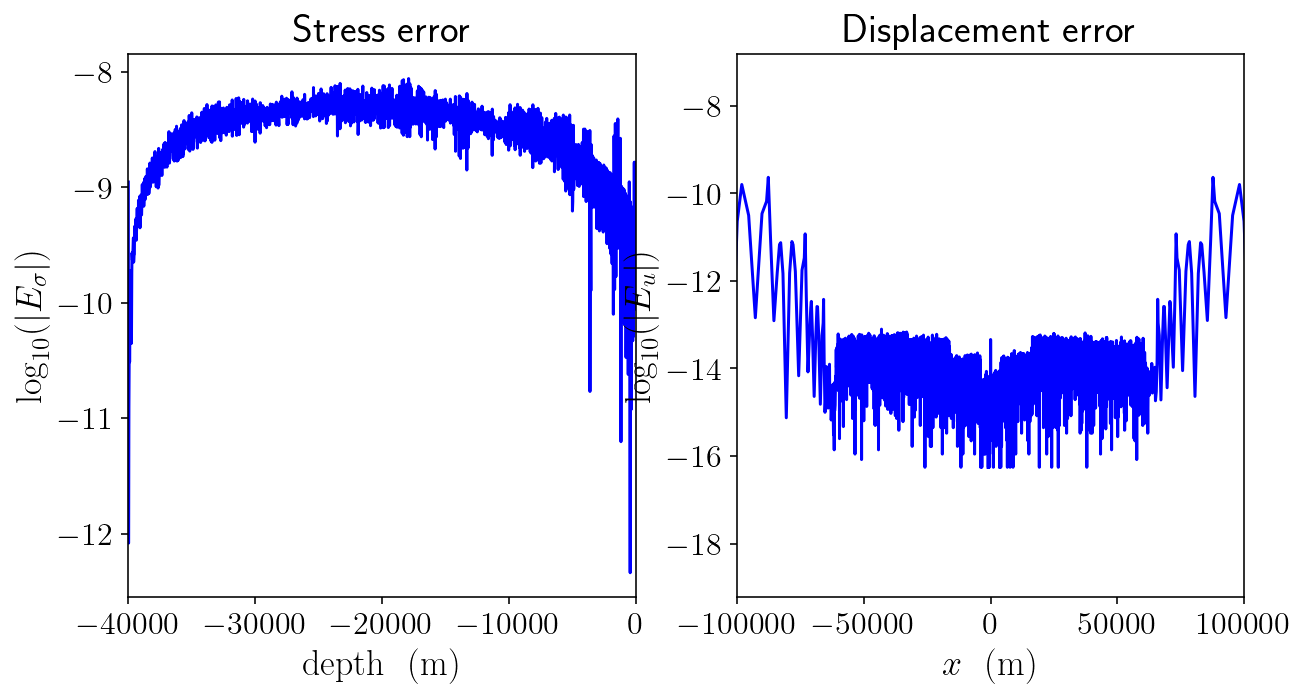

In [7]:
analytical_sd = -np.arctan(-fault_bottom / free.pts[:,0]) / np.pi
numerical_sd = Dinv.dot(-C).sum(axis=1)
rp = (fault.pts[:,1] + 1) ** 2
analytical_ft = -(shear_modulus / (2 * np.pi)) * ((1.0 / (fault.pts[:,1] + fault_bottom)) - (1.0 / (fault.pts[:,1] - fault_bottom)))
numerical_ft = total_fault_slip_to_fault_traction.sum(axis=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Stress error')
plt.plot(fault.pts[:,1], np.log10(np.abs((numerical_ft - analytical_ft)/(analytical_ft))), 'b-')
plt.xlim([-fault_bottom, 0])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\log_{10}(|E_{\sigma}|)$')
plt.subplot(1,2,2)
plt.title('Displacement error')
plt.plot(free.pts[:,0], np.log10(np.abs(numerical_sd - analytical_sd)), 'b-')
plt.xlim([-100000, 100000])
plt.xlabel('$x ~~ \mathrm{(m)}$')
plt.ylabel('$\log_{10}(|E_u|)$')
plt.show()

## Rate and state friction

Okay, now that we've constructed the necessary boundary integral operators, we get to move on to describing the frictional behavior on the fault.

#### TODO: Explain!!

In [8]:
siay = 31556952 # seconds in a year
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n = 50e6  # Normal stress (Pa)

# parameters describing "a", the coefficient of the direct velocity strengthening effect
a0 = 0.01
amax = 0.025
fy = fault.pts[:, 1]
H = 15000
h = 3000
fp_a = np.where(
    fy > -H, a0, np.where(fy > -(H + h), a0 + (amax - a0) * (fy + H) / -h, amax)
)

# state-based velocity weakening effect
fp_b = 0.015

# state evolution length scale (m)
fp_Dc = 0.008

# baseline coefficient of friction
fp_f0 = 0.6

# if V = V0 and at steady state, then f = f0, units are m/s
fp_V0 = 1e-6

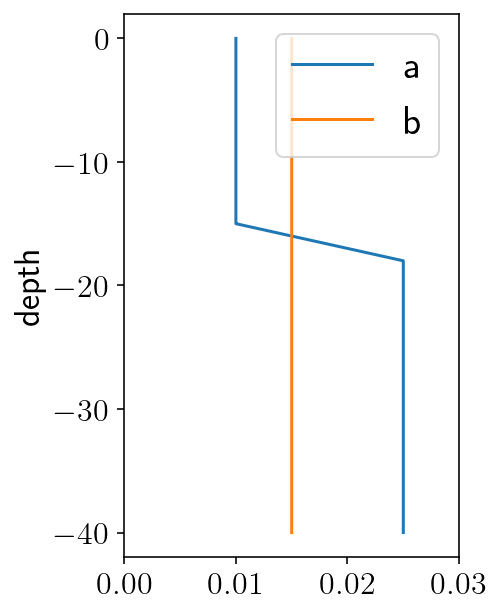

In [9]:
plt.figure(figsize=(3, 5))
plt.plot(fp_a, fy/1000, label='a')
plt.plot(np.full(fy.shape[0], fp_b), fy/1000, label='b')
plt.xlim([0, 0.03])
plt.ylabel('depth')
plt.legend()
plt.show()

First, a Python implementation of the quasidynamic shear stress equations. There are two components to a standard definition of rate and state friction:

\begin{align}
\tau_{qd} = F(V, \theta)\\
\frac{d\theta}{dt} = G(V, \theta)
\end{align}

where $F(V, \theta)$ is the strength of friction, depending on slip rate and state and $G(V, \theta)$ gives the state evolution. For $G$, we will use the aging law, given by the `aging_law` function below. 

We also need to relate the quasidynamic shear stress to the quasistatic shear stress:
\begin{equation}
\tau_{qd} = \tau_{qs} - \eta * V
\end{equation}
which results in the full quasidynamic stress balance equation:
\begin{equation}
\tau_{qs} - \eta * V - F(V, \theta) = 0
\end{equation}
The specific form we use here is  implemented below in the `qd_equation` function.

At each time step, we'll need to compute the velocity, $V$ and the state derivative $d\theta/dt$. Computing the state derivative is easy because it's directly given by the aging law. But, computing the velocity is harder because its only given implicitly in the frictional strength equation. The `solve_friction` function below implements Newton's method with a backtracking line search to solve the friction equation for the current velocity. The `qd_equation_dV` function implements the derivative of the stress balance with respect to velocity. This derivative is necessary for Newton's method.

In [10]:
# The regularized form of the aging law. 
def aging_law(fp_a, V, state):
    return (fp_b * fp_V0 / fp_Dc) * (np.exp((fp_f0 - state) / fp_b) - (V / fp_V0))

def qd_equation(fp_a, shear_stress, V, state):
    # The regularized rate and state friction equation
    F = sigma_n * fp_a * np.arcsinh(V / (2 * fp_V0) * np.exp(state / fp_a))
    
    # The full shear stress balance:
    return shear_stress - eta * V - F

def qd_equation_dV(fp_a, V, state):
    # First calculate the derivative of the friction law with respect to velocity
    # This is helpful for equation solving using Newton's method
    expsa = np.exp(state / fp_a)
    Q = (V * expsa) / (2 * fp_V0)
    dFdV = fp_a * expsa * sigma_n / (2 * fp_V0 * np.sqrt(1 + Q * Q))

    # The derivative of the full shear stress balance.
    return -eta - dFdV


def solve_friction(fp_a, shear, V_old, state, tol=1e-10):
    V = V_old
    max_iter = 150
    for i in range(max_iter):
        # Newton's method step!
        f = qd_equation(fp_a, shear, V, state)
        dfdv = qd_equation_dV(fp_a, V, state)
        step = f / dfdv

        # We know that slip velocity should not be negative so any step that
        # would lead to negative slip velocities is "bad". In those cases, we
        # cut the step size in half iteratively until the step is no longer
        # bad. This is a backtracking line search.
        while True:
            bad = step > V
            if np.any(bad):
                step[bad] *= 0.5
            else:
                break

        # Take the step and check if everything has converged.
        Vn = V - step
        if np.max(np.abs(step) / Vn) < tol:
            break
        V = Vn
        if i == max_iter - 1:
            raise Exception("Failed to converge.")

    # Return the solution and the number of iterations required.
    return Vn, i

We'll also check $h^*$ which is the minimum length scale of an instability and $L_b$, the length scale of the rupture process zone. Both these length scales need to be well resolved by the fault discretization. Here we have approximately eight point within the process zone and almost 80 points within $h^*$.

In [11]:
mesh_L = np.max(np.abs(np.diff(fault.pts[:, 1])))
Lb = shear_modulus * fp_Dc / (sigma_n * fp_b)
hstar = (np.pi * shear_modulus * fp_Dc) / (sigma_n * (fp_b - fp_a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(26.92346550528964, 341.3333333333333, 3216.990877275949)

## Quasidynamic earthquake cycle derivatives

Let's set of the last few pieces to do a full earthquake cycle simulation:
- initial conditions.
- a function to put the pieces together and calculate the full system state at each time step, including the time derivatives of slip and frictional state.
- the time stepping algorithm itself.

First, **initial conditions**. This initial state is exactly as specified in the BP-1 description linked at the top:
1. We solve for the steady frictional state at each point using `scipy.optimize.fsolve`. This is the initial state.
2. We identify the value of shear stress that will result in steady plate rate slip rates in the deeper portions of the fault: `tau_amax`. This is the initial shear stress. 
3. The initial slip deficit is zero. 

In [12]:
from scipy.optimize import fsolve
import copy

init_state_scalar = fsolve(lambda S: aging_law(fp_a, Vp, S), 0.7)[0]
init_state = np.full(fault.n_pts, init_state_scalar)
tau_amax = -qd_equation(amax, 0, Vp, init_state_scalar)

init_traction = np.full(fault.n_pts, tau_amax)
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))

Next, solving for system state. This ties the pieces together by:
1. Solving for the quasistatic shear stress using the boundary integral matrices derived at the beginning of this notebook.
2. Solving the rate and state friction equations for the slip rate.
3. Calculating the state evolution using the aging law.

The middle lines of `SystemState.calc` do these three steps. There's a bunch of other code surrounding those three lines in order to deal with invalid inputs and transform from slip to slip deficit.

In [13]:
class SystemState:

    V_old = np.full(fault.n_pts, Vp)
    state = None

    def calc(self, t, y, verbose=False):
        # Separate the slip_deficit and state sub components of the 
        # time integration state.
        slip_deficit = y[: init_slip_deficit.shape[0]]
        state = y[init_slip_deficit.shape[0] :]

        # If the state values are bad, then the adaptive integrator probably
        # took a bad step.
        if np.any((state < 0) | (state > 2.0)):
            return False

        # The big three lines solving for quasistatic shear stress, slip rate
        # and state evolution
        tau_qs = init_traction - total_fault_slip_to_fault_traction.dot(slip_deficit)
        V = solve_friction(fp_a, tau_qs, self.V_old, state)[0]
        dstatedt = aging_law(fp_a, V, state)
        if not np.all(np.isfinite(V)):
            return False
        self.V_old = V

        slip_deficit_rate = Vp - V
        out = slip_deficit, state, tau_qs, V, slip_deficit_rate, dstatedt
        self.state = out
        return self.state


def plot_system_state(SS):
    """This is just a helper function that creates some rough plots of the
    current state to help with debugging"""
    slip_deficit, state, tau_qs, slip_deficit_rate, dstatedt = SS

    plt.figure(figsize=(15, 9))
    plt.subplot(2, 3, 1)
    plt.title("slip")
    plt.plot(fault.pts[:, 1], slip_deficit)

    plt.subplot(2, 3, 2)
    plt.title("state")
    plt.plot(fault.pts[:, 1], state)

    plt.subplot(2, 3, 3)
    plt.title("tau qs")
    plt.plot(fault.pts[:, 1], tau_qs)

    plt.subplot(2, 3, 4)
    plt.title("slip rate")
    plt.plot(fault.pts[:, 1], slip_deficit_rate)

    plt.subplot(2, 3, 6)
    plt.title("dstatedt")
    plt.plot(fault.pts[:, 1], dstatedt)
    plt.tight_layout()

    plt.show()


def calc_derivatives(state, t, y):
    """
    This helper function calculates the system state and then extracts the
    relevant derivatives that the integrator needs. It also intentionally
    returns infinite derivatives when the `y` vector provided by the integrator
    is invalid.
    """
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state = state.calc(t, y)
    if not state:
        return np.inf * y
    derivatives = np.concatenate((state[-2], state[-1]))
    return derivatives

## Integrating through time

In [14]:
%%time
from scipy.integrate import RK45

# We use a 5th order adaptive Runge Kutta method and pass the derivative function to it
# the relative tolerance will be 1e-11 to make sure that even 
state = SystemState()
derivs = lambda t, y: calc_derivatives(state, t, y)
integrator = RK45
atol = Vp * 1e-6
rtol = 1e-11
rk = integrator(derivs, 0, init_conditions, 1e50, atol=atol, rtol=rtol)

# Set the initial time step to one day.
rk.h_abs = 60 * 60 * 24

# Integrate for 1000 years.
max_T = 1000 * siay

n_steps = 1000000
t_history = [0]
y_history = [init_conditions.copy()]
for i in range(n_steps):
    
    # Take a time step and store the result
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
        break
    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    # Print the time every 5000 steps
    if i % 5000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    if rk.t > max_T:
        break

y_history = np.array(y_history)
t_history = np.array(t_history)

step=0, time=0.0021812679508517504 yrs, step=0.0021812679508517504
step=5000, time=127.89911525165478 yrs, step=0.023801318650375835
step=10000, time=196.52520867873397 yrs, step=7.84832514783757e-11
step=15000, time=196.52520904304845 yrs, step=7.763707086944443e-11
step=20000, time=196.52520938788902 yrs, step=1.6032100465644325e-10
step=25000, time=256.2882393600507 yrs, step=0.02398863530147809
step=30000, time=272.1751180705654 yrs, step=1.0039328510248907e-10
step=35000, time=272.17511851240675 yrs, step=7.083740526196098e-11
step=40000, time=272.2341553093858 yrs, step=0.000311124214187668
step=45000, time=350.02872940750973 yrs, step=7.047475642956185e-11
step=50000, time=350.02872984704226 yrs, step=1.1048701093759784e-10
step=55000, time=350.0287302339869 yrs, step=1.6500521874159852e-11
step=60000, time=385.0252713662788 yrs, step=0.026779837827992592
step=65000, time=428.36064703763395 yrs, step=7.8634355158542e-11
step=70000, time=428.3606475303753 yrs, step=8.751925155232

## Plotting the results

Now that we've solved for 1000 years of fault slip evolution, let's plot some of the results. I'll start with a super simple plot of the log slip rate over time.

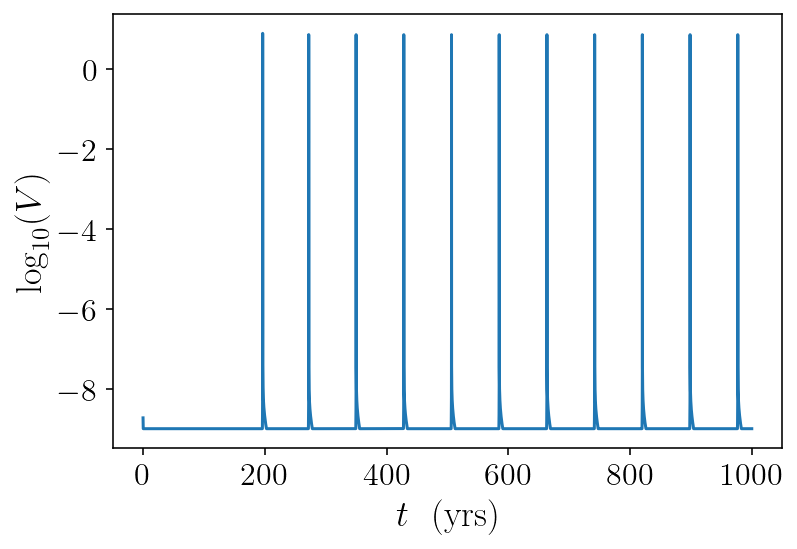

In [15]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.xlabel('$t ~~ \mathrm{(yrs)}$')
plt.ylabel('$\log_{10}(V)$')
plt.show()

And next, we'll make the classic plot showing the spatial distribution of slip over time:
- the blue lines show interseismic slip evolution and are plotted every fifteen years
- the red lines show evolution during rupture every three seconds.

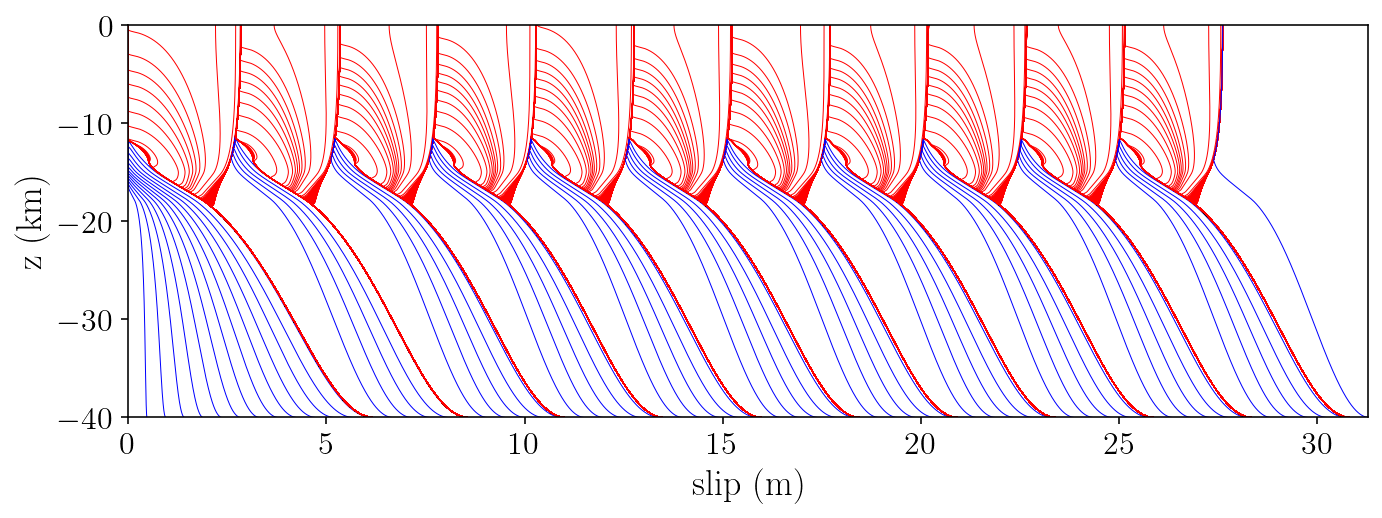

In [16]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False

    # Plot a red line every three second if the slip rate is over 0.1 mm/s.
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    
    # Plot a blue line every fifteen years during the interseismic period
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"

    if should_plot:
        # Convert from slip deficit to slip:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fy / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

And a plot of recurrence interval:

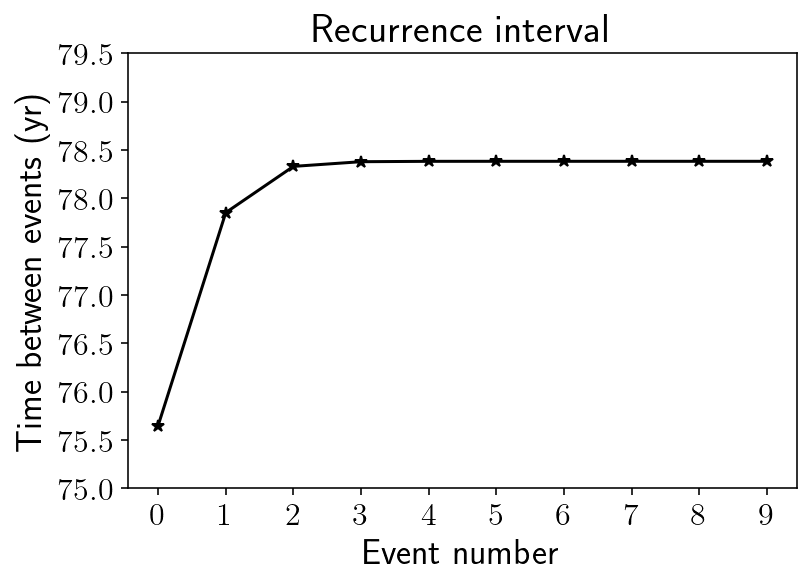

In [17]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

## Comparison against SCEC SEAS results

Finally, we will compare against the results reported as part of the SEAS project. Here, I've grabbed the time series for a point at 7500m depth on the fault from results produced by Junle Jiang.

To compare, I grab the fault history for just the first event and then interpolate the values to a depth of exactly 7500m. 

In [18]:
jiang_data = np.loadtxt("jiang7500.txt")
jiang_slip_rate = 10 ** jiang_data[:, 2]
jiang_stress = jiang_data[:, 3]

In [19]:
t_start_idx = np.argmax(max_vel > 1e-4)
t_end_idx = np.argmax(max_vel[t_start_idx:] < 1e-6)
n_steps = t_end_idx - t_start_idx
t_chunk = t_history[t_start_idx : t_end_idx]

In [20]:
shear_chunk = []
slip_rate_chunk = []
for i in range(n_steps):
    system_state = SystemState().calc(t_history[t_start_idx + i], y_history[t_start_idx + i])
    slip_deficit, state, tau_qs, V, slip_deficit_rate, dstatedt = system_state
    shear_chunk.append((tau_qs - eta * V))
    slip_rate_chunk.append(V)
shear_chunk = np.array(shear_chunk)
slip_rate_chunk = np.array(slip_rate_chunk)

In [21]:
fault_idx = np.argmax((-7480 > fy) & (fy > -7500))
VAvg = np.mean(slip_rate_chunk[:, fault_idx:(fault_idx+2)], axis=1)
SAvg = np.mean(shear_chunk[:, fault_idx:(fault_idx+2)], axis=1)

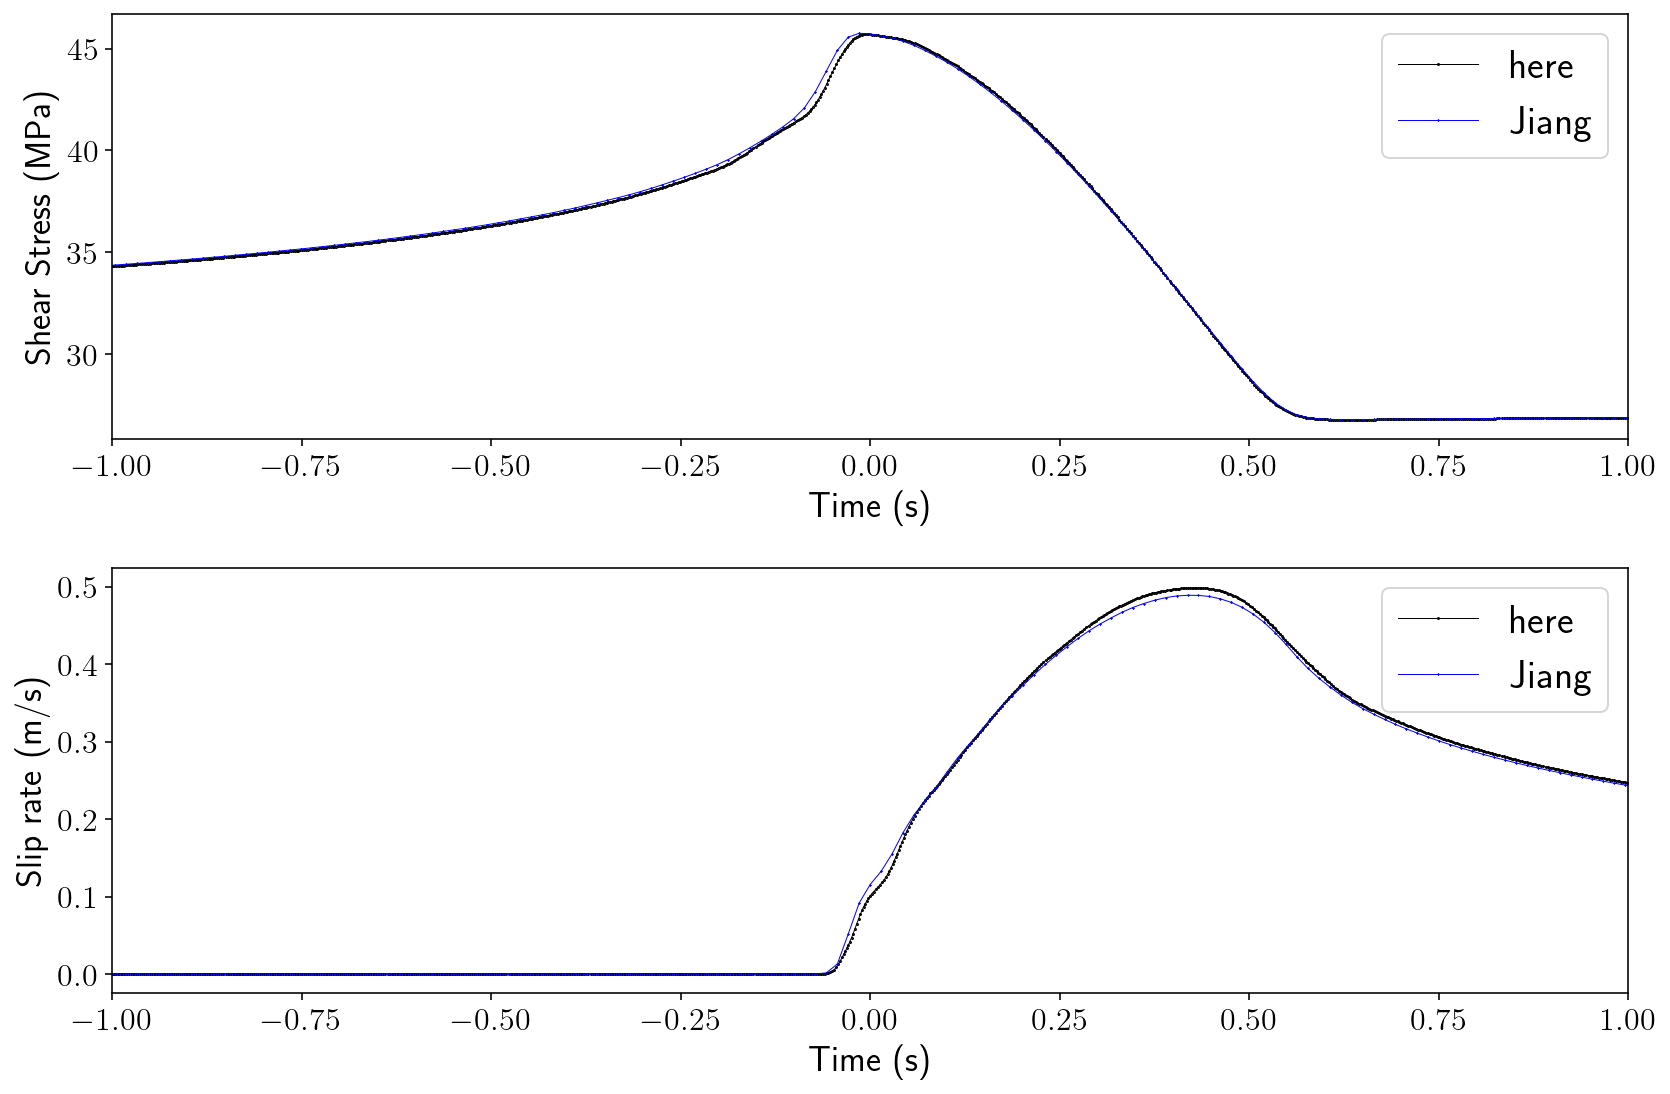

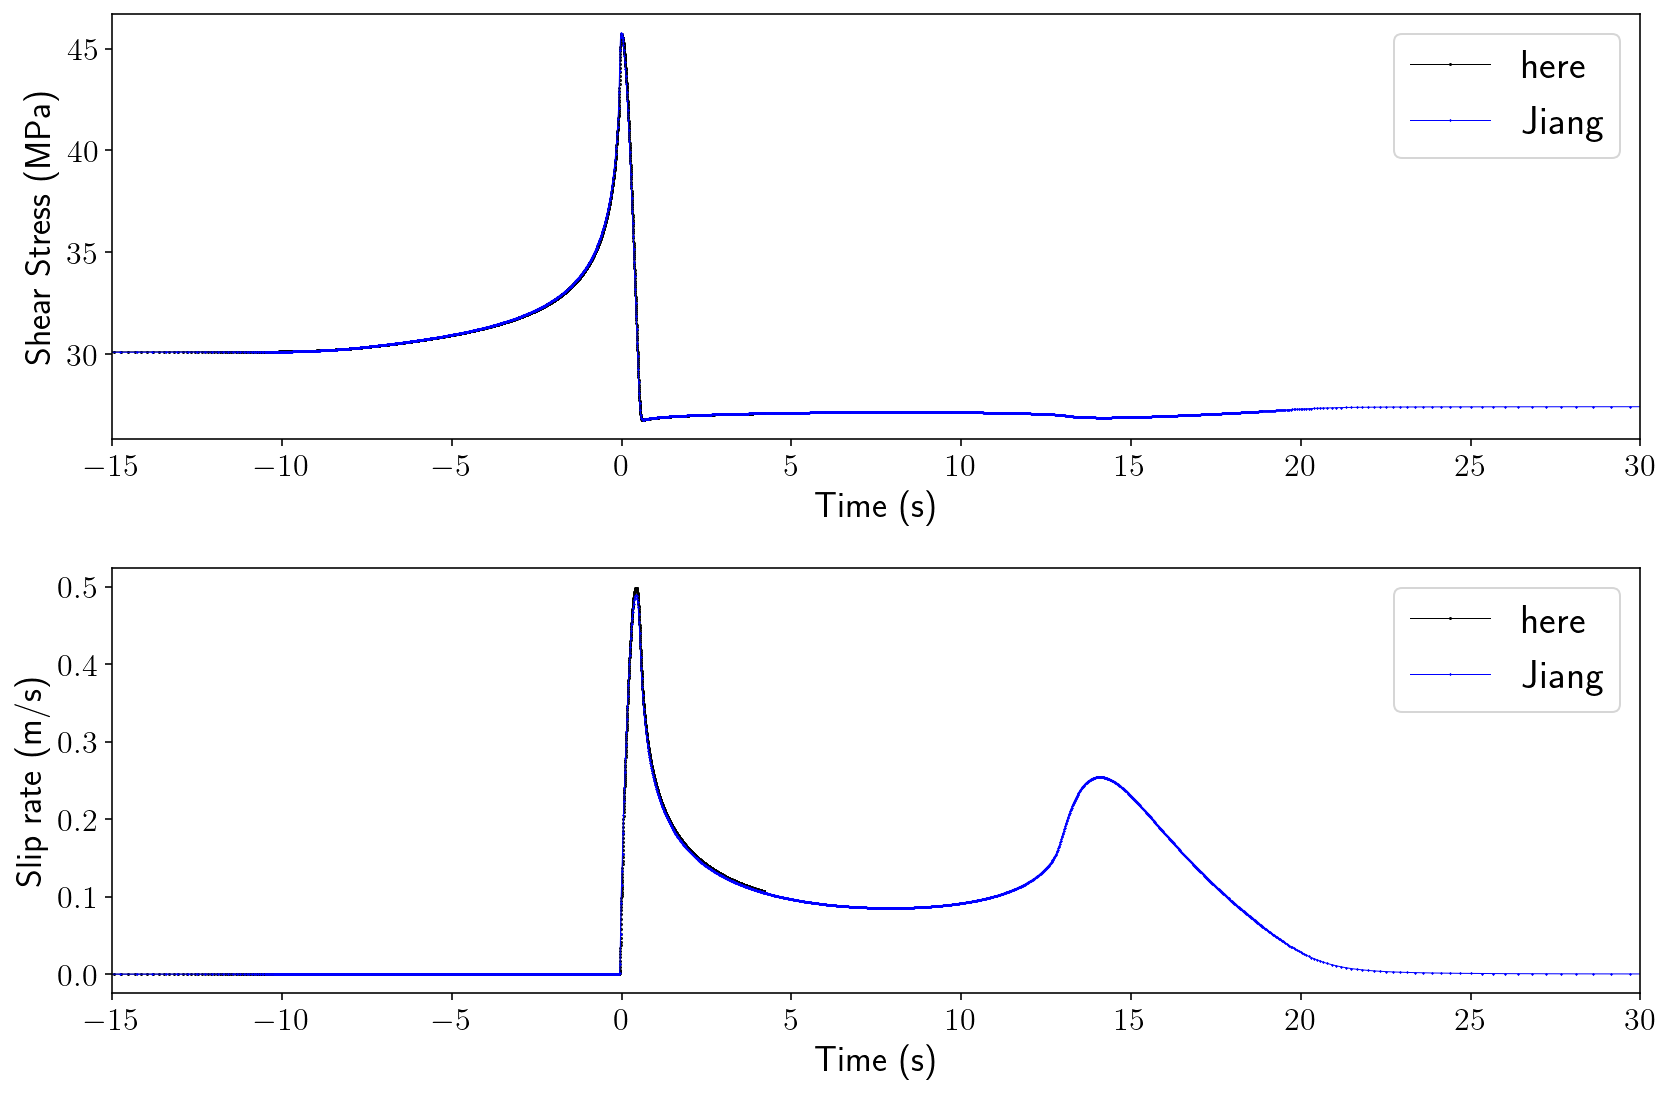

In [22]:
t_align = t_chunk[np.argmax(VAvg > 0.1)]
jiang_t_align = np.argmax(jiang_slip_rate > 0.1)

for lims in [(-1, 1), (-15, 30)]:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_chunk - t_align, SAvg / 1e6, "k-o", markersize=0.5, linewidth=0.5, label='here')
    plt.plot(
        jiang_data[:, 0] - jiang_data[jiang_t_align, 0],
        jiang_stress,
        "b-*",
        markersize=0.5,
        linewidth=0.5,
        label='Jiang'
    )
    plt.legend()
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Shear Stress (MPa)")
    # plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(t_chunk - t_align, VAvg, "k-o", markersize=0.5, linewidth=0.5, label='here')
    plt.plot(
        jiang_data[:, 0] - jiang_data[jiang_t_align, 0],
        jiang_slip_rate[:],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
        label='Jiang'
    )
    plt.legend()
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Slip rate (m/s)")
    plt.tight_layout()
    plt.show()

Why don't the solutions match more precisely? I think the most likely answer is that the Jiang result is using a 3D model that is very long in the $z$ direction but not truly infinite like the antiplane model here.